In [38]:
# In this notebook you will find the a method for creating embeddings
# using both feature categories and feature values

# Then compare a given session embedding
# using cosine similarity and drop out-of-season items 
# and ranking based on similarity in descending order
# Recommend the top K items

In [39]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

import calendar
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

In [40]:
# Read Data


item_features = pd.read_csv('dressipi_recsys2022/item_features.csv', sep=',')
clusters = pd.read_csv('clustered_features.csv')

# Read cleanned train and purchase data
purchases = pd.read_csv('train_purchases_cleanned.csv')
sessions = pd.read_csv('train_sessions_cleanned.csv')
# sessions = pd.read_csv('dressipi_recsys2022/train_sessions.csv')
# purchases = pd.read_csv('dressipi_recsys2022/train_purchases.csv')
cand_items = pd.read_csv('dressipi_recsys2022/candidate_items.csv', sep=',')


# Remove all sessions that purchased an item that is not included in candidate items
purchases = purchases[purchases.item_id.isin(cand_items.item_id)]
sessions = sessions[sessions.session_id.isin(purchases.session_id)]
sessions

,session_id,item_id,date
0,13,15654,2020-03-13 19:35:27.136
1,113,2171,2021-05-05 13:19:15.147
2,113,17218,2021-05-05 14:13:21.645
3,113,15738,2021-05-05 13:19:54.211
4,113,19760,2021-05-05 13:18:49.495
...,...,...,...
1254809,4440001,20409,2020-10-30 23:37:20.658
1254810,4440001,14155,2020-10-30 23:31:56.607
1254811,4440001,14303,2020-10-30 23:36:17.934
1254812,4440001,27852,2020-10-30 23:39:55.186


## Create a table that maps, each item to the season with the most sales

In [36]:

purchases['date'] = pd.to_datetime(purchases['date'])
purchases['year'] = purchases['date'].dt.year
purchases['month'] = purchases['date'].dt.month
sales_per_period = purchases.groupby(['year','month','item_id']).count()\
                                            .reset_index().drop('session_id',axis=1)\
                                            .sort_values(by=['item_id','year','month']).rename(columns={'date':'sales'})


def assign_season(month):
    seasons = {
    
    'winter':[11,12,1],
    'spring':[2,3,4],
    'summer':[5,6,7],
    'fall':[8,9,10]
    }
    

    for k,v in seasons.items():
        if month in seasons[k]:
            return k
    
sales_per_period['season'] = sales_per_period['month'].apply(assign_season)

In [5]:

# sales_per_period.drop_duplicates(subset='item_id',keep='first').to_csv('seasons.csv')
# sessions_sample = pd.read_csv('train_sessions_cleanned_sample.csv')
# purchases[purchases.session_id.isin(sessions_sample.session_id.unique())].to_csv('train_purchases_cleanned_sample.csv')
# random_ssids = random.sample(set(sessions.session_id.unique()),1000)
# sessions_sample = sessions[sessions.session_id.isin(random_ssids)]
# sessions_sample.to_csv('train_sessions_cleanned_sample.csv',index=False)
# purchases[purchases.session_id.isin(sessions_sample.session_id.unique())].to_csv('train_purchases_cleanned_sample.csv')

# Remove sessions with less than "N" views
Deactivated : Did not provide improvment on the results

In [6]:
# # # # only items with >1 views
# a = sessions.copy().groupby('session_id').count().reset_index()
# a = a[a.item_id>1].sort_values(by='item_id')
# # a = a[a.item_id<30]
# # # a
# sessions = sessions[sessions.session_id.isin(a.session_id)]
# purchases = purchases[purchases.session_id.isin(sessions.session_id)]


# Create embeddings for items - sessions and group all data together

In [7]:
def create_embeddings(items_df,pca_=False):
    items_df.columns = item_features.columns = ['item_id','feature_category_id','feature_value_id']
    
    # create a vector based on the values of each feature_category_id with a count of values
    value_embeddings = items_df.pivot_table(values='feature_value_id', index='feature_value_id', columns='feature_category_id', aggfunc=lambda x: len(x.unique()))
    #  return value_embeddings
    # use merge feature categories with values vector and group by .sum() to create a vector for each category
    category_embeddings = items_df.merge(value_embeddings, left_on='feature_value_id' ,right_on=value_embeddings.index).groupby('feature_category_id').sum().drop(['item_id','feature_value_id'],axis=1)

    # Adding the vectors of categories by item => provides a vector for each item
    item_embeddings = items_df.merge(category_embeddings,left_on='feature_category_id',right_on=category_embeddings.index).groupby('item_id').sum().drop(['feature_category_id','feature_value_id'],axis=1)
    
    if pca_ == True:
        pca=PCA(n_components=15)
        pca.fit(item_embeddings)
        x=pca.transform(item_embeddings)

        item_embeddings = pd.concat([pd.Series(item_embeddings.index),pd.DataFrame(x)],axis=1)
        print(item_embeddings.shape)
        return item_embeddings
    return item_embeddings


def create_session_embeddings(sessions_,item_embeddings):
    """
    takes as input the dataset of sessions, and the item embeddings
    It aggregates sessions on ssid and returns a vector that represents each session
    """
    item_embeddings = embds.reset_index()
    session_embeddings = sessions_.copy().merge(item_embeddings)\
                                        .groupby('session_id')\
                                        .sum().drop('item_id',axis=1)\
                                        .reset_index()
    return session_embeddings
    
    
def create_purchases_embeddings(purchases_,item_embeddings):
    """
    takes as input the purchases and item embeddings
    replaces item_id from purchases with the corresponding vector of the embeddings
    returns ssid and the vector of the purchased item
    """
    purchase_embeddings = purchases_.merge(item_embeddings)
    return purchase_embeddings
    

def create_train_dataset(session_embeddings,purchases_embeddings,clusters):
    """
    takes as input sessions purchases and clusters, and merges them on a big dataset
    """
#     return session_embeddings
#     session_embeddings= pd.DataFrame(session_embeddings)
#     purchases_embeddings= pd.DataFrame(purchases_embeddings)
    
    train_data = session_embeddings.merge(purchase_embeddings, on='session_id')
    train_data = train_data.sample(frac=1)
    train_data = train_data.merge(clusters[['cluster','item_id']],on='item_id')
    train_data.drop('date',axis=1,inplace=True)
    train_data.dropna(axis=0,inplace=True)
    return train_data



# create the item embeddings
embds = create_embeddings(item_features,pca_=True)
embds

# create session embeddings
session_embeddings = create_session_embeddings(sessions,embds.reset_index())
# create purchase embeddings
purchase_embeddings = create_purchases_embeddings(purchases,embds.reset_index())

# use the function create_train_dataset to combine all the dataframes into one
train_data = create_train_dataset(session_embeddings,purchase_embeddings,clusters)




# create 2 lists with column names, xc: names for session_embeddins, xy : names for item_embeddings
xc = [col for col in train_data.columns if str(col)[-1]=='x']
xy = [col for col in train_data.columns if str(col)[-1]=='y']


train_data_cluster = train_data['cluster'].values
train_data_x_vector = train_data[xc].reset_index().drop('index',axis=1).values
train_data_y_vector = train_data[xy].reset_index().drop('index',axis=1).values
train_data_session_id = train_data['session_id'].reset_index().drop('index',axis=1).values
train_data_y = train_data['item_id'].reset_index().drop('index',axis=1).values


train_data.head()

(23691, 16)


,session_id,index_x,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,6_y,7_y,8_y,9_y,10_y,11_y,12_y,13_y,14_y,cluster
0,3124028,140363,-2.166313e+09,7.784776e+08,-5.234302e+08,1.457331e+08,1.221417e+08,-4.518639e+08,-1.375012e+08,-7.185350e+08,...,7.277306e+06,-1.450290e+07,1.361472e+07,-1.302008e+06,2.418494e+06,682412.042093,-3.539262e+06,-1.121363e+06,-3.896137e+06,2
1,3128988,3688,-3.959029e+08,2.134042e+08,-1.065924e+08,-1.988780e+07,5.397673e+07,-1.631235e+08,-3.160594e+07,1.747063e+07,...,7.277306e+06,-1.450290e+07,1.361472e+07,-1.302008e+06,2.418494e+06,682412.042093,-3.539262e+06,-1.121363e+06,-3.896137e+06,2
2,3602679,26370,-1.670378e+08,8.744253e+07,7.387571e+07,4.845587e+07,1.503954e+08,-1.154330e+08,-7.049583e+07,3.812787e+07,...,7.277306e+06,-1.450290e+07,1.361472e+07,-1.302008e+06,2.418494e+06,682412.042093,-3.539262e+06,-1.121363e+06,-3.896137e+06,2
3,1067001,6234,-1.607027e+08,1.531932e+08,-5.464011e+07,-7.753619e+07,2.202821e+07,-2.417969e+06,7.277317e+06,-1.450372e+07,...,7.277306e+06,-1.450290e+07,1.361472e+07,-1.302008e+06,2.418494e+06,682412.042093,-3.539262e+06,-1.121363e+06,-3.896137e+06,2
4,3354343,44109,-8.035136e+08,7.659662e+08,-2.732006e+08,-3.876809e+08,1.101411e+08,-1.208984e+07,3.638659e+07,-7.251862e+07,...,7.277306e+06,-1.450290e+07,1.361472e+07,-1.302008e+06,2.418494e+06,682412.042093,-3.539262e+06,-1.121363e+06,-3.896137e+06,2


In [8]:
session_embeddings

,session_id,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,13,13198,3.912453e+07,2.683813e+07,9.848399e+07,7.008907e+07,-1.016276e+07,-5.718068e+07,-7.336802e+07,3.242326e+07,5.322000e+06,-6.797209e+06,2.814839e+07,2.352563e+06,6.711958e+06,1.772281e+07,8.145177e+05
1,113,69385,7.736693e+08,1.405917e+08,5.831021e+06,9.873022e+07,-7.249025e+06,1.785640e+08,-5.283795e+07,6.674592e+07,5.502785e+07,-3.244922e+07,1.484706e+07,-1.123429e+07,-7.267450e+07,-6.409021e+06,-3.077996e+07
2,115,108978,-1.285618e+09,1.225535e+09,-4.371143e+08,-6.202859e+08,1.762178e+08,-1.933427e+07,5.821845e+07,-1.160232e+08,1.089178e+08,-1.041607e+07,1.934795e+07,5.459296e+06,-2.831410e+07,-8.970904e+06,-3.116910e+07
3,140,37109,-1.003507e+07,1.709593e+08,3.602756e+08,-1.183097e+08,-5.802413e+07,1.680953e+07,2.010672e+08,-3.361232e+06,-4.529708e+07,-4.651008e+07,-5.865144e+07,-1.578589e+07,-1.366576e+07,-1.263250e+06,9.349168e+06
4,153,21898,-6.358043e+06,1.943406e+08,3.460121e+08,-1.120943e+08,-1.247309e+08,4.853046e+06,1.921897e+08,-4.291470e+06,-4.581260e+07,-4.486662e+07,-5.813917e+07,-1.636244e+07,-1.166564e+07,-2.069785e+06,8.946961e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289325,4439936,20050,-2.119348e+06,6.478021e+07,1.153374e+08,-3.736477e+07,-4.157698e+07,1.617682e+06,6.406322e+07,-1.430490e+06,-1.527087e+07,-1.495554e+07,-1.937972e+07,-5.454147e+06,-3.888546e+06,-6.899285e+05,2.982320e+06
289326,4439952,21987,1.589713e+08,-4.271606e+05,-4.000015e+07,-5.927561e+06,-9.927880e+06,6.960281e+06,-7.255445e+06,-3.788210e+06,8.567296e+06,-4.479868e+06,-1.326441e+07,4.622037e+05,2.649518e+07,8.959552e+06,-3.373853e+06
289327,4439954,4527,1.589713e+08,-4.271606e+05,-4.000015e+07,-5.927561e+06,-9.927880e+06,6.960281e+06,-7.255445e+06,-3.788210e+06,8.567296e+06,-4.479868e+06,-1.326441e+07,4.622037e+05,2.649518e+07,8.959552e+06,-3.373853e+06
289328,4439986,92891,-1.271609e+07,3.886813e+08,6.920242e+08,-2.241886e+08,-2.494619e+08,9.706093e+06,3.843793e+08,-8.582939e+06,-9.162519e+07,-8.973325e+07,-1.162783e+08,-3.272488e+07,-2.333128e+07,-4.139571e+06,1.789392e+07


In [9]:

class topN_results:
    """
    Class to store the top n results.
    initialize and then use the plus one method
    self.correct will be used as a simple counter
    
    Inputs: 
        n_top: <int> number of top K 
        results: <list> a list of the reccomended items in descending order
        y_true: the true target variable
        
    output:
        self.correct: int
        Use self.correct as a variable to plot results
    """
    def __init__(self):
        self.correct = 0
        
        
    def plus_one(self,n_top,results,y_true):
        if y_true in results[:n_top]:
            self.correct +=1

# Evaluation of the model
#### To evaluate the algorithm we will loop over a N number of samples from the dataset
#### On each loop, a random session will be picked and compared with all the other sessions
#### Then a ranking based on the similarity of the sessions and items will rank all the purchased
####     items from the dataset, and by filtering the items based on the seasons, the to K items will 
####     reccomended.
#### Using the top items that have been selected, we will check if the purchased item is one of them.
####     Then we will create a score, for the correct recommendations

In [33]:
top1000 = topN_results()
top500 = topN_results()
top200 = topN_results()
top100 = topN_results()
top50 = topN_results()
top20 = topN_results()
top10 = topN_results()
top5 = topN_results()
top1 = topN_results()

def get_similarities(test_session_embeddings, # one session embedding
                     train_session_embeddings, # all the other session embeddings
                     train_purchased_item, # the corresponding item of session embeddings
                     train_session_cluster, # The corresponding cluster
                     train_session_id,# session ids
                     item_vector, # item embeddings
                     test_session_id # the session id of the current session
                    ):
    
    # use the custom function cosine_similarity to return a table with the similarity of a given session
    # with all the other sessions along with information of the cluster and the purchased items
    sim = cosine_similarity([test_session_embeddings],train_session_embeddings)
    results = pd.DataFrame(sim.T)
    
    
    results = pd.concat([results,pd.DataFrame(train_purchased_item)],axis=1) # add item_id (y_train)
    results = pd.concat([results,pd.DataFrame(train_session_cluster)],axis=1) # add cluster of session
    results = pd.concat([results,pd.DataFrame(train_session_id)],axis=1) # add session_id
    results.columns = ['similarities','item_id','cluster','session_id'] # rename dataframe

    item_sim = cosine_similarity([test_session_embeddings],item_vector)
    item_sim = pd.DataFrame(item_sim.T)
    
    results = pd.concat([results,item_sim],axis=1)
    results.rename(columns={0:'item_sim'},inplace=True)
    results = results[results.session_id!=test_session_id] # exclude from similarities test session id
    return results.sort_values(by=['similarities','item_sim'],ascending=False)


counts = 0
counts_method2= 0
n_samples = 200
sample_ = 0



for ssid in random.sample(set(sessions.session_id.unique()),n_samples):
    test_session_id = ssid
    # get the information needed from the dataset for a random ssid
    
    # y_true
    test_purchased_item = purchases[purchases.session_id==test_session_id]['item_id'].values[0]
    
    # what is the month and season that the session occured
    test_month = purchases[purchases.session_id==test_session_id]['month'].values[0]
    test_season = assign_season(test_month)
    
    # from which cluster the purchased item (y_true) belongs
    test_purchased_item_class = clusters[clusters['item_id']==test_purchased_item]['cluster'].values[0]
    
    # the embeddings for the given session
    test_session_embeddings = sessions[sessions.session_id==test_session_id].merge(embds.reset_index()).iloc[:,-len(embds.columns):].sum().tolist()
    
    
    # Compare the session with all the other sessions
    # results contain ['similarities', 'item_id', 'cluster', 'session_id', 'item_sim']
    results = get_similarities(test_session_embeddings,
                                   train_data_x_vector,
                                   train_data_y,
                                   train_data_cluster,
                                   train_data_session_id,
                                   train_data_y_vector,
                                   test_session_id
                                  )

    
    # add teh season on the results based on the items & filter out of season items
    results = results.merge(sales_per_period[['item_id','season']])
    results = results[results['season']==test_season]
    

    # create an average similarity between the similarities [session to session & session to items]
#     results['av_sim']=(results['similarities'] + results['item_sim'])/2
        
    # Drop duplicates to get only unique items on the recommendation
    results = results.drop_duplicates(subset='item_id',keep='first')
    
#     # plot similarities
#     plt.figure(figsize=(12,8))
#     plt.title('Distribution of similarities')
#     results.similarities.hist(bins=100,label='distribution')
#     counts2, binEdges2=np.histogram(results.item_sim,bins=100)
#     plt.vlines(results.similarities.mean(),0,counts2.max(),color='red',label='mean')
#     plt.legend()
#     plt.show()
    
    top1000.plus_one(1000, results['item_id'].tolist(), test_purchased_item )
    top500.plus_one(500, results['item_id'].tolist(), test_purchased_item )
    top200.plus_one(200, results['item_id'].tolist(), test_purchased_item )
    top100.plus_one(100, results['item_id'].tolist(), test_purchased_item )
    top50.plus_one(50, results['item_id'].tolist(), test_purchased_item )
    top20.plus_one(20, results['item_id'].tolist(), test_purchased_item )
    top10.plus_one(10, results['item_id'].tolist(), test_purchased_item )
    top5.plus_one(5, results['item_id'].tolist(), test_purchased_item )
    top1.plus_one(1, results['item_id'].tolist(), test_purchased_item )

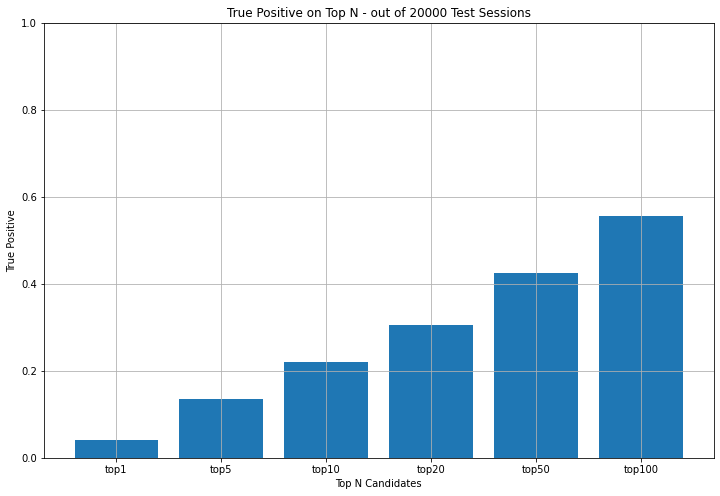

In [34]:
tops = [top1.correct,top5.correct,top10.correct,top20.correct,
        top50.correct,top100.correct]

tops2 = [t/n_samples for t in tops]

plt.figure(figsize=(12,8))
plt.bar(['top1','top5','top10','top20','top50','top100'],tops2)
plt.ylim(0,1)
plt.xlabel('Top N Candidates')
plt.ylabel('True Positive')
plt.grid()
plt.title(f'True Positive on Top N - out of {n_samples} Test Sessions')
plt.show()

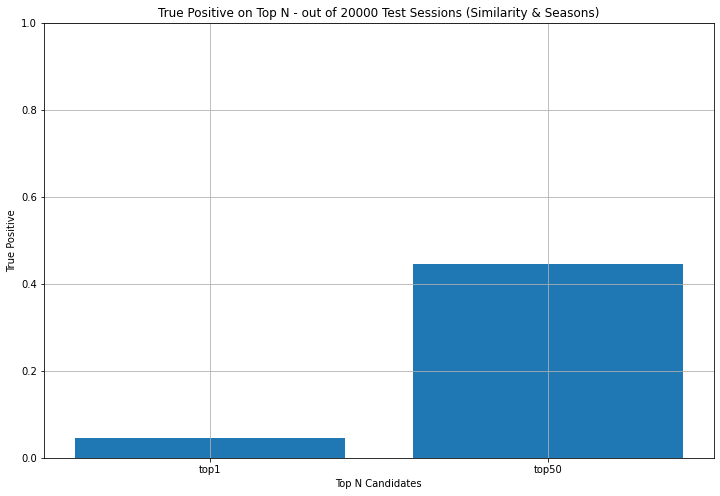

In [25]:
tops = [top1.correct,
        top50.correct]

tops2 = [t/n_samples for t in tops]

plt.figure(figsize=(12,8))
plt.bar(['top1','top50'],tops2)
plt.ylim(0,1)
plt.xlabel('Top N Candidates')
plt.ylabel('True Positive')
plt.grid()
plt.title(f'True Positive on Top N - out of {n_samples} Test Sessions (Similarity & Seasons)')
plt.show()

In [36]:
purchases.item_id.nunique()

930